In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a forcasting problem, where the goal is to predict the number of cycles an engine will last before it fails.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis. -> 🎯 **Focus on this task**
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization.
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.


# Imports + Settings

In [3]:
!pip install pytorch-lightning
!pip install colorlog
!pip install bayesian-optimization
!pip install pandas
!pip install plotly
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
# third-party libraries
import pandas as pd
import numpy as np
import os
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from bayes_opt import BayesianOptimization

import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# source code
from src.data_loading import load_data, load_config
from src.data_splitting import train_val_split_by_group
from src.nn_utils import create_sliding_window, create_sliding_window_test
from src.rolling_window_creator import calculate_RUL
from src.data_processing import apply_padding_on_train_data_and_test_data, drop_samples_with_clipped_values
from src.nn_util.nn_models.ligthning.cnnModel1 import CNNModel1 as CNNModel
from src.nn_util.datamodule.lightning.turbofanDatamodule import TurbofanDatamodule
from src.data_cleaning import clean_data

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')

In [6]:
np.random.seed(42)

# Paths

In [7]:
# Make sure to execute this cell only once for one kernel session, before running any other cell below.
os.chdir("../../") # set working directory to root of project
os.getcwd() # check current working directory

'C:\\Users\\Johannes\\PycharmProjects\\damage-propagation-modeling'

In [8]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load Config + Data

In [9]:
config = load_config(PATH_TO_CONFIG) # config is dict

In [10]:
train_data, test_data, test_RUL_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=1)

2024-05-31 22:44:57 [src.data_loading:43] [INFO] >>>> Loading data set 1...
2024-05-31 22:44:57 [src.data_loading:72] [INFO] >>>> Loaded raw data for dataset 1.
2024-05-31 22:44:57 [src.data_loading:73] [INFO] >>>> Train Data: (20631, 26)
2024-05-31 22:44:57 [src.data_loading:74] [INFO] >>>> Test Data: (13096, 26)
2024-05-31 22:44:57 [src.data_loading:75] [INFO] >>>> Test RUL Data: (100, 1)


# Hyperparameter Search for CNNModel1 for dataset FD001

First search space:
* learning rate initialisation: (0.00001, 0.1)
* batch size: (10, 200)
* dropout: (0.01, 0.5)
* betas (of classifier Adam): beta_1 (0.8, 0.999) and beta_2 (0.9, 0.999999)

Second search space: Because the results were not good enough from the first search, we searched around the hyperparameters of the best model from the first search space.
* learning rate initialisation: (0.01, 0.1)
* batch size: (110, 115)
* dropout: (0.05, 0.1)
* betas (of classifier Adam): beta_1 (0.9, 0.99) and beta_2 (0.95, 0.99)

Iterations: 50 (each)

In [11]:
# some hyperparameters
time_column = 'Cycle'
group_column = 'UnitNumber'

window_size = 30
clip_value = 125
apply_data_cleaning = True

# Apply scaler. The order in the list represents the order in which they are applied
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
scaler = [std_scaler, minmax_scaler, robust_scaler]

# The model_type can be 'CNN_2D' or 'CNN_1D' and defines what type of convolutional layers has been used.
model_type = 'CNN_1D' 

# Setting the seed
pl.seed_everything(21)

Seed set to 21


21

In [12]:
if apply_data_cleaning:
    train_data, test_data = clean_data(train_data, test_data, method=None, ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.0, contamination=0.05)
    
# Add column RUL to train_data
train_data = calculate_RUL(train_data, time_column, group_column, clip_value)

train_data, test_data = apply_padding_on_train_data_and_test_data(train_data=train_data, test_data=test_data, window_size=window_size)

X_test, _ = create_sliding_window_test(test_data, column_RUL=False, drop_columns=['UnitNumber'])
y_test = test_RUL_data.values

train, val = train_val_split_by_group(train_data, test_size=0.1, random_state=12)

X_train, y_train = create_sliding_window(train, window_size=window_size)  #, drop_columns=['UnitNumber', 'Cycle, 'RUL'])
X_val, y_val = create_sliding_window(val, window_size=window_size)  #, drop_columns=['UnitNumber', 'Cycle', 'RUL'])

X_train, y_train = drop_samples_with_clipped_values(X_train, y_train, clip_value)
X_val, y_val = drop_samples_with_clipped_values(X_val, y_val, clip_value)

2024-05-31 22:44:58 [src.data_cleaning:134] [INFO] >>>> Cleaning train and test data...
2024-05-31 22:44:58 [src.data_cleaning:136] [INFO] >>>> Formatting column types...
2024-05-31 22:44:58 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-31 22:44:58 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-31 22:44:58 [src.data_cleaning:141] [INFO] >>>> Handling duplicates...
2024-05-31 22:44:58 [src.data_cleaning:146] [INFO] >>>> Removing outliers...
2024-05-31 22:44:58 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: None ...
2024-05-31 22:44:58 [src.outlier_detection:162] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-31 22:44:58 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: None ...
2024-05-31 22:44:58 [src.outlier_detection:162] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-31 22:44:58 [src.data_cleaning:

Scale the data

In [13]:
X_train_shape = X_train.shape
X_val_shape = X_val.shape
X_test_shape = X_test.shape

# Note: Do not normalize the cycle value! That is why we start with one
for single_scaler in scaler:
    for i in range(1, X_train.shape[-1]):
        X_train[:, :, i] = single_scaler.fit_transform(X_train[:, :, i])
        X_val[:, :, i] = single_scaler.transform(X_val[:, :, i])
        X_test[:, :, i] = single_scaler.transform(X_test[:, :, i])

Change data types of arrays to float32 and swap axes if necessary:

In [14]:
model_type = 'CNN_1D'

print(X_train.shape)
if model_type == 'CNN_1D':
    X_train = np.swapaxes(X_train, 1, 2)
elif model_type == 'CNN_2D':
    X_train = np.swapaxes(X_train, 1, 2)
    X_train = X_train[:, np.newaxis, :, :]
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
print(X_train.shape)

print(X_val.shape)
if model_type == 'CNN_1D':
    X_val = np.swapaxes(X_val, 1, 2)
elif model_type == 'CNN_2D':
    X_val = np.swapaxes(X_val, 1, 2)
    X_val = X_val[:, np.newaxis, :, :]
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
print(X_val.shape)

print(X_test.shape)
if model_type == 'CNN_1D':
    X_test = np.swapaxes(X_test, 1, 2)
elif model_type == 'CNN_2D':
    X_test = np.swapaxes(X_test, 1, 2)
    X_test = X_test[:, np.newaxis, :, :]
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
print(X_test.shape)

(11250, 30, 18)
(11250, 18, 30)
(1260, 30, 18)
(1260, 18, 30)
(100, 30, 18)
(100, 18, 30)


## Hyperparameter Search 

In [ ]:
from sklearn.metrics import root_mean_squared_error
import torch 
# Setting the seed
pl.seed_everything(21)

def hyperparameter_function_cnn(learning_rate_init, batch_size, dropout, beta_1, beta_2):
    """ Function for hyperparameter optimization
    """    
    # Select hyperparameters of trainer!
    checkpoint_callback = ModelCheckpoint(monitor="val_loss")
    trainer = Trainer(min_epochs=1, max_epochs=150, callbacks=[checkpoint_callback], deterministic=True)
    datamodule = TurbofanDatamodule(batch_size=int(batch_size), random_state=15)
    datamodule.set_train_dataset(X_train, y_train)
    datamodule.set_val_dataset(X_val, y_val)
    datamodule.set_predict_dataset(X_test)
    datamodule.set_test_dataset(X_test, y_test)
    model = CNNModel(lr=learning_rate_init, window_size=window_size, features=18, dropout_rate=dropout, beta_1=beta_1, beta_2=beta_2)
    trainer.fit(model, datamodule=datamodule)
    pred = trainer.validate(model, datamodule=datamodule, ckpt_path='best')
    return - pred[0]['val_loss']
    

# Bounded region of parameter space
pbounds = {'learning_rate_init': (0.00001, 0.1), 'batch_size': (10, 200), 'dropout': (0.01, 0.5), 'beta_1': (0.8, 0.999), 'beta_2': (0.9, 0.999999)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_cnn,
    pbounds=pbounds,
    random_state=14,
)
optimizer.maximize(
    init_points=20,
    n_iter=30,
)

In [16]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': -380.0711669921875, 'params': {'batch_size': 107.64923531681114, 'beta_1': 0.9538598453637801, 'beta_2': 0.9870418981447955, 'dropout': 0.013943004779610777, 'learning_rate_init': 0.03098049519126536}}
Iteration 1: 
	{'target': -623.3966674804688, 'params': {'batch_size': 191.94471047951927, 'beta_1': 0.9021102257413096, 'beta_2': 0.931828124202785, 'dropout': 0.27420796933856756, 'learning_rate_init': 0.022133281693351714}}
Iteration 2: 
	{'target': -1321.9324951171875, 'params': {'batch_size': 163.2314580056113, 'beta_1': 0.8681086704973222, 'beta_2': 0.9538883460178654, 'dropout': 0.012878154920018581, 'learning_rate_init': 0.06731851629327074}}
Iteration 3: 
	{'target': -3635.07421875, 'params': {'batch_size': 49.90460981396025, 'beta_1': 0.9855789609828637, 'beta_2': 0.9374241007033998, 'dropout': 0.37868527182211376, 'learning_rate_init': 0.07631626879453375}}
Iteration 4: 
	{'target': -1321.942626953125, 'params': {'batch_size': 175.39489650163253, 'bet

In [17]:
threshold = 500
under_threshold_indices = np.arange(len(optimizer.res))[np.array([- optimizer.res[i]["target"] for i in range(len(optimizer.res))]) < threshold]
under_threshold = [optimizer.res[i] for i in under_threshold_indices]

In [18]:
under_threshold

[{'target': -380.0711669921875,
  'params': {'batch_size': 107.64923531681114,
   'beta_1': 0.9538598453637801,
   'beta_2': 0.9870418981447955,
   'dropout': 0.013943004779610777,
   'learning_rate_init': 0.03098049519126536}},
 {'target': -388.8275451660156,
  'params': {'batch_size': 39.080953225229784,
   'beta_1': 0.8977959224520511,
   'beta_2': 0.9010728278918141,
   'dropout': 0.3270620437930545,
   'learning_rate_init': 0.007238704901270764}}]

In [19]:
max_params = optimizer.max['params']
print(optimizer.max)

{'target': -380.0711669921875, 'params': {'batch_size': 107.64923531681114, 'beta_1': 0.9538598453637801, 'beta_2': 0.9870418981447955, 'dropout': 0.013943004779610777, 'learning_rate_init': 0.03098049519126536}}


In [ ]:
def hyperparameter_function_cnn(learning_rate_init, batch_size, dropout, beta_1, beta_2):
    """ Function for hyperparameter optimization
    """    
    # Select hyperparameters of trainer!
    checkpoint_callback = ModelCheckpoint(monitor="val_loss")
    trainer = Trainer(min_epochs=1, max_epochs=150, callbacks=[checkpoint_callback], deterministic=True)
    datamodule = TurbofanDatamodule(batch_size=int(batch_size), random_state=15)
    datamodule.set_train_dataset(X_train, y_train)
    datamodule.set_val_dataset(X_val, y_val)
    datamodule.set_predict_dataset(X_test)
    datamodule.set_test_dataset(X_test, y_test)
    model = CNNModel(lr=learning_rate_init, window_size=window_size, features=18, dropout_rate=dropout, beta_1=beta_1, beta_2=beta_2)
    trainer.fit(model, datamodule=datamodule)
    pred = trainer.validate(model, datamodule=datamodule, ckpt_path='best')
    return - pred[0]['val_loss']
    

# Bounded region of parameter space
pbounds = {'learning_rate_init': (0.01, 0.1), 'batch_size': (100, 115), 'dropout': (0.005, 0.1), 'beta_1': (0.9, 0.99), 'beta_2': (0.95, 0.99)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_cnn,
    pbounds=pbounds,
    random_state=17,
    allow_duplicate_points=True,
)
optimizer.maximize(
    init_points=20,
    n_iter=30,
)

In [17]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': -1321.940185546875, 'params': {'batch_size': 104.41997504030664, 'beta_1': 0.9477528080044765, 'beta_2': 0.9576608314778997, 'dropout': 0.01145053402817268, 'learning_rate_init': 0.0808286913999922}}
Iteration 1: 
	{'target': -545.5281982421875, 'params': {'batch_size': 109.84500282663782, 'beta_1': 0.9573768806439272, 'beta_2': 0.9730241157501214, 'dropout': 0.008710977037942316, 'learning_rate_init': 0.04220322440351941}}
Iteration 2: 
	{'target': -208.14474487304688, 'params': {'batch_size': 114.18524780227611, 'beta_1': 0.9054040212283847, 'beta_2': 0.9845616841418484, 'dropout': 0.08834259998406288, 'learning_rate_init': 0.014607429905840833}}
Iteration 3: 
	{'target': -398.7694091796875, 'params': {'batch_size': 109.78627923198482, 'beta_1': 0.9496576231771388, 'beta_2': 0.973900530129562, 'dropout': 0.0509352193094502, 'learning_rate_init': 0.03546893447712921}}
Iteration 4: 
	{'target': -1321.97802734375, 'params': {'batch_size': 104.46588577452657, 'b

In [19]:
max_params = optimizer.max['params']
print(optimizer.max)

{'target': -136.14785766601562, 'params': {'batch_size': 114.84809532072403, 'beta_1': 0.9586517323123119, 'beta_2': 0.9558431375026947, 'dropout': 0.021025382021542985, 'learning_rate_init': 0.01}}


In [2]:
list_of_results = [
	{'target': -1321.940185546875, 'params': {'batch_size': 104.41997504030664, 'beta_1': 0.9477528080044765, 'beta_2': 0.9576608314778997, 'dropout': 0.01145053402817268, 'learning_rate_init': 0.0808286913999922}},
	{'target': -545.5281982421875, 'params': {'batch_size': 109.84500282663782, 'beta_1': 0.9573768806439272, 'beta_2': 0.9730241157501214, 'dropout': 0.008710977037942316, 'learning_rate_init': 0.04220322440351941}},
	{'target': -208.14474487304688, 'params': {'batch_size': 114.18524780227611, 'beta_1': 0.9054040212283847, 'beta_2': 0.9845616841418484, 'dropout': 0.08834259998406288, 'learning_rate_init': 0.014607429905840833}},
	{'target': -398.7694091796875, 'params': {'batch_size': 109.78627923198482, 'beta_1': 0.9496576231771388, 'beta_2': 0.973900530129562, 'dropout': 0.0509352193094502, 'learning_rate_init': 0.03546893447712921}},
	{'target': -1321.97802734375, 'params': {'batch_size': 104.46588577452657, 'beta_1': 0.9505358014793726, 'beta_2': 0.965841897441881, 'dropout': 0.07992656741949547, 'learning_rate_init': 0.047663594681128935}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 102.15855881162992, 'beta_1': 0.9135816024978609, 'beta_2': 0.9522096540086329, 'dropout': 0.07321353340184635, 'learning_rate_init': 0.036308561905372475}},
	{'target': -1321.9326171875, 'params': {'batch_size': 102.98160808300514, 'beta_1': 0.9748227530079469, 'beta_2': 0.9727196447889852, 'dropout': 0.012822276175185672, 'learning_rate_init': 0.059049871653764845}},
	{'target': -1321.94091796875, 'params': {'batch_size': 102.38438116850914, 'beta_1': 0.9609086147132664, 'beta_2': 0.954738890595163, 'dropout': 0.04727462628140654, 'learning_rate_init': 0.08991841907414791}},
	{'target': -1321.9326171875, 'params': {'batch_size': 111.95901594992965, 'beta_1': 0.9061180855437264, 'beta_2': 0.9884315102586712, 'dropout': 0.06762451227572207, 'learning_rate_init': 0.07468984749019912}},
	{'target': -1321.9388427734375, 'params': {'batch_size': 111.15365147701145, 'beta_1': 0.9798962716697073, 'beta_2': 0.9553578267030317, 'dropout': 0.07881258515753013, 'learning_rate_init': 0.08541923609757926}},
	{'target': -1321.9332275390625, 'params': {'batch_size': 112.43957145862642, 'beta_1': 0.9026241296867829, 'beta_2': 0.9656149796510634, 'dropout': 0.04653893925596388, 'learning_rate_init': 0.05685715571601987}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 107.39309011248527, 'beta_1': 0.9117386353987758, 'beta_2': 0.9893753412397789, 'dropout': 0.011241720582218107, 'learning_rate_init': 0.062135566996966304}},
	{'target': -5567.80078125, 'params': {'batch_size': 108.71162237630092, 'beta_1': 0.9858904079001232, 'beta_2': 0.957897751100547, 'dropout': 0.01291591305988848, 'learning_rate_init': 0.08954777959599135}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 100.23544289426415, 'beta_1': 0.9716035182618172, 'beta_2': 0.9807276175771324, 'dropout': 0.0878441596655512, 'learning_rate_init': 0.09244990777505997}},
	{'target': -287.2508239746094, 'params': {'batch_size': 104.10719789376677, 'beta_1': 0.921274301374434, 'beta_2': 0.9624207937458155, 'dropout': 0.07298610959725503, 'learning_rate_init': 0.017446194032806304}},
	{'target': -1321.9329833984375, 'params': {'batch_size': 110.13229664506639, 'beta_1': 0.9772672201989774, 'beta_2': 0.9777158753646602, 'dropout': 0.07958295067007332, 'learning_rate_init': 0.04179531266025576}},
	{'target': -1321.9329833984375, 'params': {'batch_size': 103.30288103565606, 'beta_1': 0.9220835151413775, 'beta_2': 0.9790965006229693, 'dropout': 0.01109213842570985, 'learning_rate_init': 0.050836371574798624}},
	{'target': -1321.93359375, 'params': {'batch_size': 107.31515994202823, 'beta_1': 0.9576787346500045, 'beta_2': 0.9542467540945335, 'dropout': 0.059492944091098565, 'learning_rate_init': 0.096431121462164}},
	{'target': -833.483642578125, 'params': {'batch_size': 107.73520870296309, 'beta_1': 0.9512842541305362, 'beta_2': 0.9895202664628571, 'dropout': 0.08412273883156096, 'learning_rate_init': 0.054832931389359664}},
	{'target': -1321.932373046875, 'params': {'batch_size': 101.20227006796046, 'beta_1': 0.9783942294658466, 'beta_2': 0.978523456359497, 'dropout': 0.07455064413579024, 'learning_rate_init': 0.08412579883180138}},
	{'target': -159.756591796875, 'params': {'batch_size': 104.11587650425484, 'beta_1': 0.9119246839760772, 'beta_2': 0.9610651608417315, 'dropout': 0.052730945624881044, 'learning_rate_init': 0.014936946074819988}},
	{'target': -171.6083526611328, 'params': {'batch_size': 114.65947309612879, 'beta_1': 0.9026386508240088, 'beta_2': 0.9884924884736225, 'dropout': 0.09640110938754486, 'learning_rate_init': 0.01}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 114.02367453852989, 'beta_1': 0.9705829128042498, 'beta_2': 0.9815748281328865, 'dropout': 0.0733333582672995, 'learning_rate_init': 0.069100904237037}},
	{'target': -2109.54345703125, 'params': {'batch_size': 114.38956443431937, 'beta_1': 0.9862451488076193, 'beta_2': 0.9642269834256233, 'dropout': 0.011012197429450196, 'learning_rate_init': 0.09055635890919857}},
	{'target': -166.67971801757812, 'params': {'batch_size': 114.90308043489712, 'beta_1': 0.9, 'beta_2': 0.99, 'dropout': 0.1, 'learning_rate_init': 0.01}},
	{'target': -1321.9327392578125, 'params': {'batch_size': 103.82271313571842, 'beta_1': 0.9094401944982297, 'beta_2': 0.9546935530699182, 'dropout': 0.005979711122501248, 'learning_rate_init': 0.0943450606635863}},
	{'target': -1321.932861328125, 'params': {'batch_size': 109.50388223093424, 'beta_1': 0.9773418029616014, 'beta_2': 0.9664911293053134, 'dropout': 0.011729119444058548, 'learning_rate_init': 0.09540765463072036}},
	{'target': -374.5850830078125, 'params': {'batch_size': 104.11045468266447, 'beta_1': 0.9030804765383255, 'beta_2': 0.9607147356878234, 'dropout': 0.0711287547989292, 'learning_rate_init': 0.014781621827490977}},
	{'target': -1321.9345703125, 'params': {'batch_size': 108.62981779786573, 'beta_1': 0.9749961297183678, 'beta_2': 0.9532342258608173, 'dropout': 0.05889174584930653, 'learning_rate_init': 0.054378956087651}},
	{'target': -177.40127563476562, 'params': {'batch_size': 114.81644271583559, 'beta_1': 0.9009367800260817, 'beta_2': 0.9894642880082647, 'dropout': 0.09872169611957977, 'learning_rate_init': 0.01}},
	{'target': -1321.9609375, 'params': {'batch_size': 111.65460046212912, 'beta_1': 0.9424793129731927, 'beta_2': 0.9692576761581062, 'dropout': 0.09390636200068134, 'learning_rate_init': 0.06661466723389609}},
	{'target': -231.04949951171875, 'params': {'batch_size': 114.73339369380565, 'beta_1': 0.9508149599491471, 'beta_2': 0.99, 'dropout': 0.1, 'learning_rate_init': 0.01}},
	{'target': -158.19349670410156, 'params': {'batch_size': 114.73156805354867, 'beta_1': 0.9, 'beta_2': 0.9599201143943352, 'dropout': 0.030172709400534896, 'learning_rate_init': 0.01}},
	{'target': -149.1744842529297, 'params': {'batch_size': 108.58303556956479, 'beta_1': 0.9528741620672433, 'beta_2': 0.9862703873676469, 'dropout': 0.056748836949525705, 'learning_rate_init': 0.0112286551298623}},
	{'target': -136.14785766601562, 'params': {'batch_size': 114.84809532072403, 'beta_1': 0.9586517323123119, 'beta_2': 0.9558431375026947, 'dropout': 0.021025382021542985, 'learning_rate_init': 0.01}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 114.82320945901952, 'beta_1': 0.9084958544266059, 'beta_2': 0.99, 'dropout': 0.03450845770304992, 'learning_rate_init': 0.1}},
	{'target': -765.0653686523438, 'params': {'batch_size': 114.87581571841858, 'beta_1': 0.99, 'beta_2': 0.95, 'dropout': 0.1, 'learning_rate_init': 0.01}},
	{'target': -1321.9998779296875, 'params': {'batch_size': 108.48126182167286, 'beta_1': 0.9555279511953672, 'beta_2': 0.962874556382797, 'dropout': 0.08282211842886554, 'learning_rate_init': 0.0279033537305688}},
	{'target': -1321.93408203125, 'params': {'batch_size': 108.47027541557846, 'beta_1': 0.9867765189166716, 'beta_2': 0.9886295337116932, 'dropout': 0.07755285776454766, 'learning_rate_init': 0.09678169767549794}},
	{'target': -228.16873168945312, 'params': {'batch_size': 114.6652924481292, 'beta_1': 0.9797942432827215, 'beta_2': 0.95, 'dropout': 0.028932020798033954, 'learning_rate_init': 0.01}},
	{'target': -1321.9324951171875, 'params': {'batch_size': 111.08851616315746, 'beta_1': 0.9284501871958212, 'beta_2': 0.9815987345062374, 'dropout': 0.029784977857423768, 'learning_rate_init': 0.06785633901891487}},
	{'target': -390.2870788574219, 'params': {'batch_size': 114.22833672321403, 'beta_1': 0.952884409677686, 'beta_2': 0.9844047231018811, 'dropout': 0.09826131802753861, 'learning_rate_init': 0.01940848479338708}},
	{'target': -1321.9326171875, 'params': {'batch_size': 104.18689313750303, 'beta_1': 0.984921059033588, 'beta_2': 0.9641066759484411, 'dropout': 0.022019878722495313, 'learning_rate_init': 0.031122613040309124}},
	{'target': -148.25955200195312, 'params': {'batch_size': 114.9350392229255, 'beta_1': 0.9, 'beta_2': 0.95, 'dropout': 0.005, 'learning_rate_init': 0.01}},
	{'target': -652.656982421875, 'params': {'batch_size': 104.05887957628134, 'beta_1': 0.9260254386639507, 'beta_2': 0.9875250749852202, 'dropout': 0.007263984313147391, 'learning_rate_init': 0.049610506267929656}},
	{'target': -514.7868041992188, 'params': {'batch_size': 105.15289621152307, 'beta_1': 0.9511321230376667, 'beta_2': 0.9680456851053519, 'dropout': 0.09937994468252238, 'learning_rate_init': 0.04044781610377655}},
	{'target': -202.99290466308594, 'params': {'batch_size': 115.0, 'beta_1': 0.9, 'beta_2': 0.95, 'dropout': 0.08796740161093751, 'learning_rate_init': 0.01}},
	{'target': -419.4583435058594, 'params': {'batch_size': 101.9913880551069, 'beta_1': 0.9439848214673604, 'beta_2': 0.981016628737828, 'dropout': 0.017980255254174866, 'learning_rate_init': 0.03187089661564653}},
	{'target': -151.94140625, 'params': {'batch_size': 114.98833082683562, 'beta_1': 0.9807024020413586, 'beta_2': 0.99, 'dropout': 0.012096043207637693, 'learning_rate_init': 0.01}},
	{'target': -1321.9329833984375, 'params': {'batch_size': 115.0, 'beta_1': 0.9091925386100123, 'beta_2': 0.99, 'dropout': 0.02691317867064523, 'learning_rate_init': 0.09226652534940223}}]

In [14]:
list_of_results_only_values = [[-list_of_results[i]['target']] + list(list_of_results[i]['params'].values()) for i in range(len(list_of_results))]
df_results = pd.DataFrame(list_of_results_only_values, columns=['target'] + list(list_of_results[0]['params'].keys()))

<Figure size 640x480 with 0 Axes>

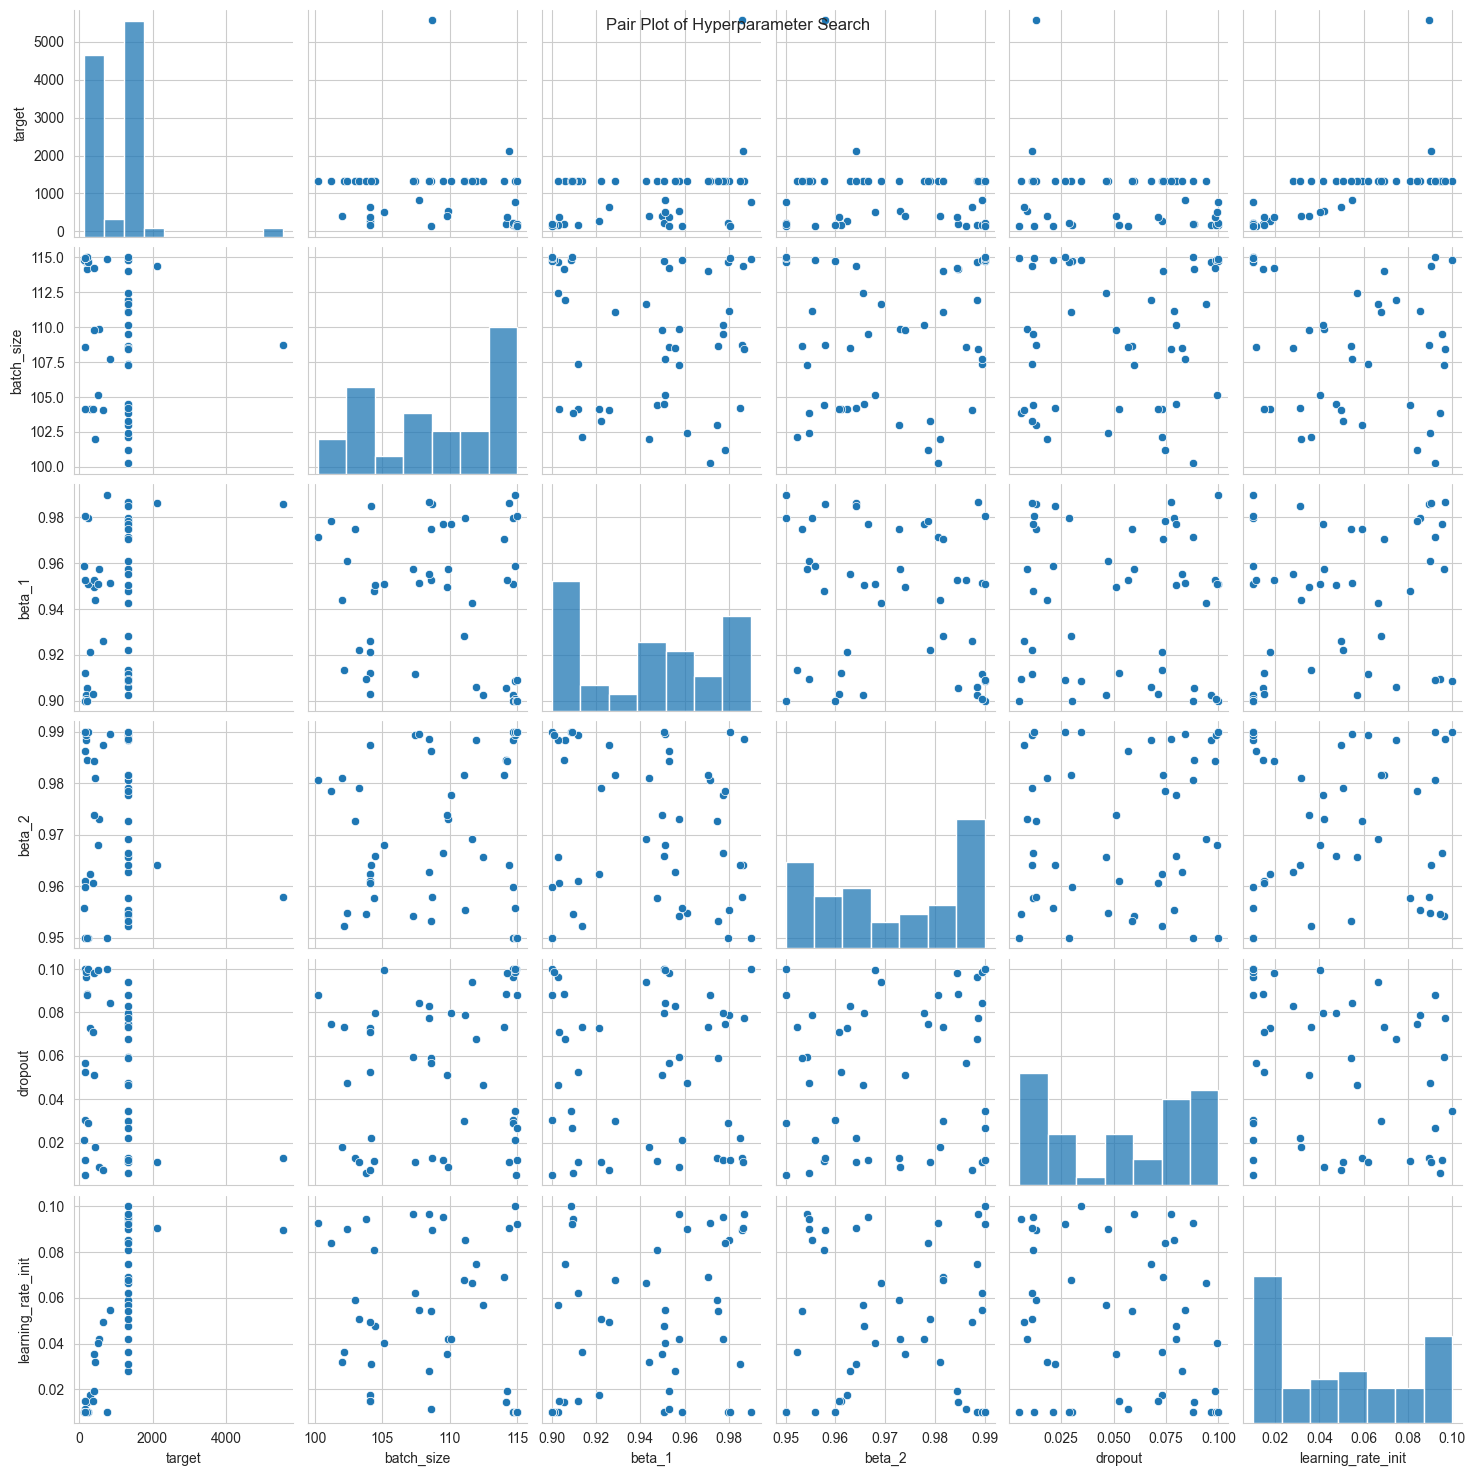

In [16]:
plt.figure()
sns.pairplot(df_results)
plt.suptitle('Pair Plot of Hyperparameter Search')
plt.show()

<Figure size 640x480 with 0 Axes>

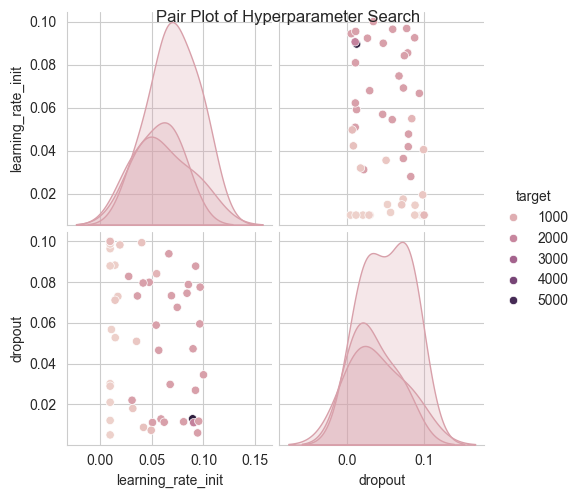

In [26]:
plt.figure()
sns.pairplot(df_results[['target', 'learning_rate_init', 'dropout']], hue='target')
plt.suptitle('Pair Plot of Hyperparameter Search')
plt.show()

<Figure size 640x480 with 0 Axes>

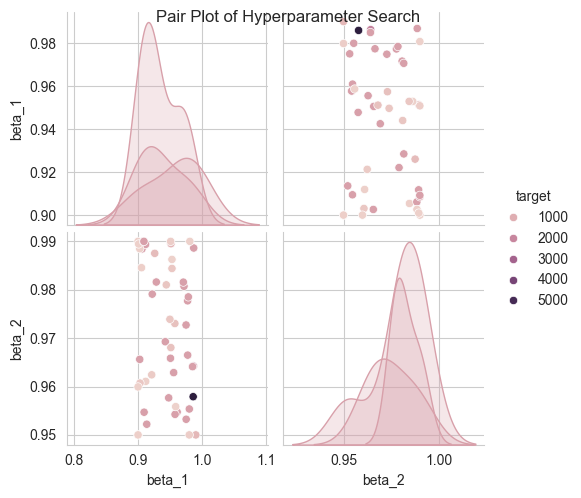

In [27]:
plt.figure()
sns.pairplot(df_results[['target', 'beta_1', 'beta_2']], hue='target')
plt.suptitle('Pair Plot of Hyperparameter Search')
plt.show()

<Figure size 640x480 with 0 Axes>

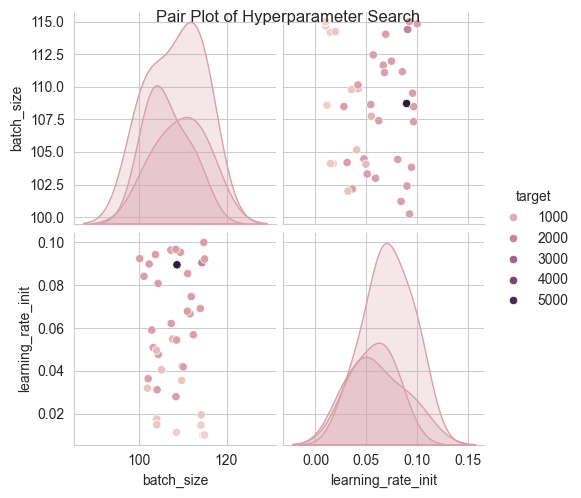

In [28]:
plt.figure()
sns.pairplot(df_results[['target', 'batch_size', 'learning_rate_init']], hue='target')
plt.suptitle('Pair Plot of Hyperparameter Search')
plt.show()